<a href="https://colab.research.google.com/github/budim12/papr/blob/master/Paper_mylog_history_gps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()


Saving LotionHtry.json to LotionHtry.json


In [3]:
uploaded["LotionHtry.json"].decode("utf-8").split("\r\n")

['{\n  "locations" : [ {\n    "timestampMs" : "1452767314116",\n    "latitudeE7" : -72824885,\n    "longitudeE7" : 1127323334,\n    "accuracy" : 1630\n  }, {\n    "timestampMs" : "1452767329520",\n    "latitudeE7" : -72818417,\n    "longitudeE7" : 1127308286,\n    "accuracy" : 4\n  }, {\n    "timestampMs" : "1452767344520",\n    "latitudeE7" : -72818585,\n    "longitudeE7" : 1127308313,\n    "accuracy" : 5\n  }, {\n    "timestampMs" : "1452767360531",\n    "latitudeE7" : -72811920,\n    "longitudeE7" : 1127305945,\n    "accuracy" : 3\n  }, {\n    "timestampMs" : "1452767376526",\n    "latitudeE7" : -72804602,\n    "longitudeE7" : 1127310700,\n    "accuracy" : 5\n  }, {\n    "timestampMs" : "1452767391541",\n    "latitudeE7" : -72797649,\n    "longitudeE7" : 1127306067,\n    "accuracy" : 4\n  }, {\n    "timestampMs" : "1452767407525",\n    "latitudeE7" : -72804956,\n    "longitudeE7" : 1127313547,\n    "accuracy" : 4\n  }, {\n    "timestampMs" : "1452767423543",\n    "latitudeE7" : -728

In [0]:
import pandas as pd
import io

In [5]:
io.StringIO(uploaded["LotionHtry.json"].decode("utf-8"))

In [7]:
df_gps = pd.read_json('LotionHtry.json')
print('There are {:,} rows'.format(len(df_gps)))

There are 3,888 rows


In [0]:
# parse lat, lon from the dict inside the locations column and convert to decimalized degrees
df_gps['lat'] = df_gps['locations'].map(lambda x: x['latitudeE7']) / 10.**7
df_gps['lon'] = df_gps['locations'].map(lambda x: x['longitudeE7']) / 10.**7

In [0]:
# parse timestamp in seconds from locations column and convert to datetime
df_gps['timestamp_s'] = (df_gps['locations'].map(lambda x: x['timestampMs']).astype(float) / 1000).astype(int)
df_gps['datetime'] = pd.to_datetime(df_gps['timestamp_s'], unit='s')

In [0]:
# filter out points with altitudes above 3000 meters to remove airplane data
df_gps['altitude'] = df_gps['locations'].map(lambda x: x['altitude'] if 'altitude' in x else None)
mask = (df_gps['altitude'] < 3000) | (pd.isnull(df_gps['altitude']))
df_gps = df_gps[mask]

In [0]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [0]:
# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt

# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

In [0]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [0]:
import time
def dbscan_reduce(df, epsilon, x='lon', y='lat'):
    start_time = time.time()
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    coords = df.as_matrix(columns=[y, x])    
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()
    
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))    
    return rs

In [21]:
# first cluster the full gps location history data set coarsely, with epsilon=5km in radians
eps_rad = 15 / kms_per_radian
df_clustered = dbscan_reduce(df_gps, epsilon=eps_rad)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


Number of clusters: 8
Clustered 3,888 points down to 8 points, for 99.79% compression in 0.38 seconds.


In [24]:
# Another story

sample_rate = 50
df_sampled = df_gps.iloc[range(0, len(df_gps), sample_rate)]
len(df_sampled)

78

In [0]:
# combine the clustered and sampled sets
df_combined = pd.concat([df_clustered, df_sampled], axis=0)
df_combined = df_combined.reset_index().drop(labels='index', axis=1)

In [26]:
# then reduce by clustering again, finely this time with epsilon=0.1km in radians
eps_rad = 0.1 / kms_per_radian
df_final = dbscan_reduce(df_combined, epsilon=eps_rad)

Number of clusters: 55
Clustered 86 points down to 55 points, for 36.05% compression in 0.12 seconds.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:
df_final.to_csv('location-history-clustered.csv', index=False, encoding='utf-8')

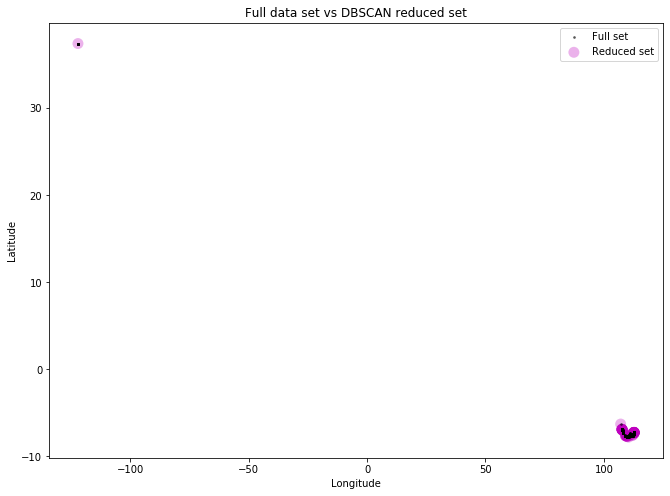

In [29]:
# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['lon'], df_final['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_gps['lon'], df_gps['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

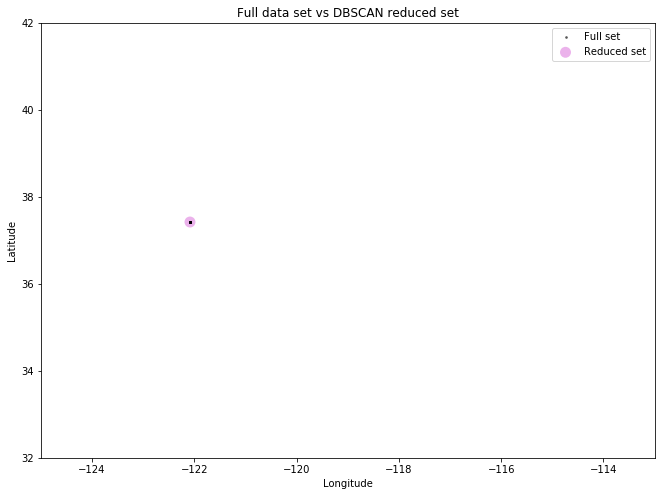

In [30]:
# show a map of only the california data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['lon'], df_final['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_gps['lon'], df_gps['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-125, -113])
ax.set_ylim([32, 42])
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()